<a href="https://colab.research.google.com/github/Nusserle/sentiment_learning/blob/master/sentiment_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Functions**

In [0]:
def read_in(path_to_file):
    """
    Reads in training and test data and removes all neutral tweets
    from test data because the training data lacks neutral.
    Due to hardware restrictions we used only 1/10th of the available 
    training dataset (160.000 tweets)
    """
    out = []
    with open(path_to_file, encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
            out.append([row[1], row[2]])
    return out

def read_in2(path_to_file):
  out = []
  with open(path_to_file, encoding='latin-1') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for row in csv_reader:
          if row.__len__() > 0:
            out.append([row[0], row[1]])
  return out


def preprocess(data):
    """
    Preprocesses and tokenizes data
    """
    label = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        cleaned = clean_regex(row[1])
        if cleaned.__len__() > 1:
            if row[0] == "0":
                label.append(0)
            else:
                label.append(1)
            tokenized = nltk.word_tokenize(cleaned)
            # pos_tagged = nltk.pos_tag(tokenized)
            tweet.append(tokenized)
    print("Done")
    return tweet, label

def preprocess2(data):
    """
    Preprocesses and tokenizes data
    """
    ids = []
    tweet = []
    print("Preprocessing...")
    for row in data:
        cleaned = clean_regex(row[1].lower())
        if cleaned.__len__() > 1:
            tokenized = nltk.word_tokenize(cleaned)
            # pos_tagged = nltk.pos_tag(tokenized)
            tweet.append(tokenized)
            ids.append(row[0])
    print("Done")
    return tweet, ids


def clean_regex(tweet):
    """
    Regex that removes links to other users, and all hyperlink mentions
    """
    hashtags = re.findall('#[a-z]*?[A-Z][A-Z|a-z]*', tweet)
    for hashtag in hashtags:
      replacement = ' '.join(re.sub( r"([A-Z])", r" \1", hashtag).split())
      tweet = tweet.replace(hashtag, replacement).lower()
    cleaned0 = re.sub('\$&@\*#', 'fuck', tweet)
    cleaned1 = re.sub('@.*?(?:\s|$)', '', cleaned0)
    cleaned2 = re.sub('http.*?(?:\s|$)', '', cleaned1)
    cleaned3 = re.sub('www.*?(?:\s|$)', '', cleaned2)
    cleaned4 = re.sub('#','', cleaned3)
    return cleaned4

def parse_to_dict(file_path):
    """
    Creates hashmap with word as key and concept vector as value
    :param file_path: path to the conceptnet dictionary file
    :return: hashmap of word and vectors
    """
    concept_hash = {}
    with open(file_path, encoding="utf8") as f:
        text = f.readlines()[1:]
        for line in text:
            first_item = line.split(" ").__getitem__(0)
            concept_hash[first_item] = line
    f.close()
    return concept_hash

def find_word(word, concept_hash):
    """
    Finds conceptnet vector for a word in the conceptnet hashmap
    :param word: input word to analyze
    :param concept_hash: hashmap of word and conceptnet vector
    :return: returns the appropriate vector or none if its not in the hashmap
    """
    if word in concept_hash.keys():
        vector = concept_hash[word].split(" ")[1:]
        vector = [float(i) for i in vector]
    else:
        vector = None
    return vector
  
def get_embeddings(sentences):
    """
    Retrieves a 300 dim. embedding vector from ConceptNet for each word 
    of a sentence. (Only retrieves the first 40 words (tokens) of a tweet)
    """
    max_words = 60
    results = np.zeros((len(sentences), max_words, 300))
    for i, sent in enumerate(sentences):
        if i % 25000 == 0:
            print(str(i))
        for j, word in enumerate(sent):
            if j < max_words:
                embedding = find_word(word.lower(), concept_hash)
                if embedding is not None:
                    for k, val in enumerate(embedding):
                        results[i][j][k] = val
                else:
                    for k in range(300):
                        results[i][j][k] = 0.0
    return results

def fill_list(data, max_dim=35):
  """
  Fills or cuts list of tokens for a tweet at 35, to ensure consistent vector dimensions
  """
  res = []
  for row in data:
      copy = row
      if len(row) < max_dim:
          copy += [''] * (max_dim - len(row))
      elif len(row) > max_dim:
          copy = row[:max_dim]   
      res.append(copy)
  return res

#def write_to_file(file_name, data, label):
#  f= open("preprocessed","w+")


In [0]:
from google.colab import files
files.upload()

In [0]:
!git clone https://github.com/HIT-SCIR/ELMoForManyLangs
!pip install allennlp
%cd ELMoForManyLangs/
%ls
!python setup.py install
!wget http://vectors.nlpl.eu/repository/11/144.zip
!unzip 144.zip
%rm "config.json"

In [0]:
from google.colab import files
files.upload()

In [0]:
%cd ..

/content


In [0]:
from elmoformanylangs import Embedder
e = Embedder('ELMoForManyLangs/')

In [0]:
pip install bert-embedding

In [0]:
from bert_embedding import BertEmbedding
bert_embedding = BertEmbedding()

In [0]:
bert_embedding(["This is a test sentence", "This as well"] )

**Preprocessing**

In [28]:

#base_path = "C:/Users/Tobias.Nusser/PycharmProjects/sentiment_learning"
#base_path = os.getcwd()
# 140.000 entries
training_data, training_label = preprocess(read_in("train_2kmZucJ.csv"))
test_data, test_label = preprocess2(read_in2("test_oJQbWVk.csv"))

Preprocessing...
Done
Preprocessing...
Done


In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(60, activation='relu', input_shape=(60,300,)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(60, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

**Split into training and validation set**

In [0]:
split_at = 7000
train_data = training_data[:split_at]
train_label = np.asarray(training_label[:split_at])
val_data = training_data[split_at:]
val_label = np.asarray(training_label[split_at:])

In [0]:
train_embedding_matrix = np.asarray(e.sents2elmo(fill_list(train_data)))
val_embedding_matrix = np.asarray(e.sents2elmo(fill_list(val_data)))

In [0]:
out_array = np.zeros(shape=(train_data.__len__(),10,768))
for i, row in enumerate(train_data):
  if i % 5 == 0:
    print(i)
  vec = bert_embedding(row)
  for j, word_vec in enumerate(vec):
    if j < 10:
      out_array[i][j] = word_vec[1][0]
  #print(type(bert_embedding(row)[0]))
#train_embedding_matrix = bert_embedding(fill_list(train_data))
#val_embedding_matrix = bert_embedding(fill_list(val_data))

0
5
10
15


KeyboardInterrupt: ignored

In [0]:

file = !wget https://conceptnet.s3.amazonaws.com/downloads/2017/numberbatch/numberbatch-en-17.06.txt.gz
  
import gzip
import shutil
with gzip.open("numberbatch-en-17.06.txt.gz",'rb') as f_in:
    with open('numberbatch-en.txt','wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

**Load ConceptNet word embeddings in RAM**

In [0]:
concept_hash = parse_to_dict("numberbatch-en.txt")

**Retrieve word embedding vectors for training and validation data**

In [30]:
train_embedding_matrix = get_embeddings(train_data)
val_embedding_matrix = get_embeddings(val_data)

0
0


In [0]:
print(train_embedding_matrix.dtype)
print(train_embedding_matrix.shape)
print(val_embedding_matrix.shape)

float64
(7000, 60, 300)
(920, 60, 300)


**Neural Network Model**

Sequential model with three Dense Layers and one Flatten layer to flatten 3D input matrix.
*Relu* as activation function and simple *sigmoid* function for the output layer. Because of the binary classification task we used a simple *accuracy* metric and *binary crossentropy* as loss function. As optimizer we used *rmsprop*, which performed best according to some tests.

In [0]:
from keras.callbacks import ModelCheckpoint

model = models.Sequential()
model.add(layers.LSTM(64, activation='tanh' ,input_shape=(60,300,)))
#model.add(layers.GRU(64, activation='tanh', input_shape=(60,300,)))
#model.add(layers.Flatten())
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=0.00205),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])
print(model.summary())
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(train_embedding_matrix,
                    train_label,
                    epochs=55,
                    batch_size=512,
                    validation_data=(val_embedding_matrix, val_label), verbose=1, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60, 64)            93440     
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 122,433
Trainable params: 122,433
Non-trainable params: 0
_________________________________________________________________
None
Train on 7000 samples, validate on 920 samples
Epoch 1/55
7000/7000 [==============================] - 7s 1ms/step - loss: 0.5911 - acc: 0.7190 - val_loss: 0.4047 - val_acc: 0.7522

Epoch 00001: val_acc improved from -inf to 0.75217, saving model to weights.best.

**Plotting accuracy and loss in the training phase**

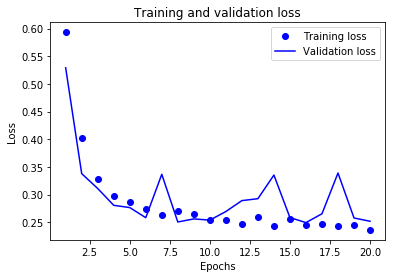

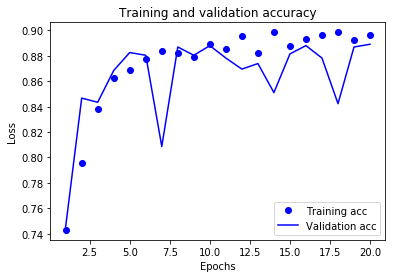

In [87]:
# Loss plot
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Evaluating model on test data**

In [0]:
test_label = np.asarray(test_label)
#test_embedding_matrix = get_embeddings(test_data)
test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
results = model.evaluate(test_embedding_matrix, test_label)
print("Loss: ", results[0])
print("Accuracy: ", results[1])

359/359 [==============================] - 0s 140us/step
Loss:  0.6674792934260992
Accuracy:  0.7047353763766275


In [0]:
%ls

ELMoForManyLangs/            output.csv        train_2kmZucJ.csv
numberbatch-en-17.06.txt.gz  sample_data/
numberbatch-en.txt           test_oJQbWVk.csv


In [33]:
test_data, test_id = preprocess2(read_in2("test_oJQbWVk.csv"))
test_embedding_matrix = get_embeddings(test_data)
#test_embedding_matrix = np.asarray(e.sents2elmo(fill_list(test_data)))
print(test_embedding_matrix.shape)

Preprocessing...
Done
0
(1953, 60, 300)


In [0]:
model.load_weights("weights.best.hdf5")

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 60, 60)            18060     
_________________________________________________________________
flatten_16 (Flatten)         (None, 3600)              0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 3600)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 60)                216060    
_________________________________________________________________
dropout_32 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 61        
Total params: 234,181
Trainable params: 234,181
Non-trainable params: 0
_________________________________________________________________


In [0]:
prediction = model.predict(test_embedding_matrix)

In [0]:
output = []
for i, pred in enumerate(prediction):
  if pred > 0.5:
    output.append([test_id[i], "1"])
  else:
    output.append([test_id[i], "0"])
with open('output.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerow(["id", "label"])
    writer.writerows(output)


In [91]:
%ls
from google.colab import files
files.download('output.csv')

numberbatch-en-17.06.txt.gz    output.csv        train_2kmZucJ.csv
numberbatch-en-17.06.txt.gz.1  sample_data/      weights.best.hdf5
numberbatch-en.txt             test_oJQbWVk.csv


In [0]:
print(output)

[['1', '7921'], ['0', '7922'], ['1', '7923'], ['0', '7924'], ['1', '7925'], ['0', '7926'], ['1', '7927'], ['0', '7928'], ['1', '7929'], ['0', '7930'], ['0', '7931'], ['0', '7932'], ['0', '7933'], ['0', '7934'], ['0', '7935'], ['0', '7936'], ['0', '7937'], ['1', '7938'], ['1', '7939'], ['0', '7940'], ['0', '7941'], ['0', '7942'], ['0', '7943'], ['0', '7944'], ['1', '7945'], ['0', '7946'], ['0', '7947'], ['0', '7948'], ['1', '7949'], ['0', '7950'], ['1', '7951'], ['1', '7952'], ['0', '7953'], ['0', '7954'], ['0', '7955'], ['1', '7956'], ['1', '7957'], ['0', '7958'], ['0', '7959'], ['0', '7960'], ['0', '7961'], ['0', '7962'], ['0', '7963'], ['0', '7964'], ['0', '7965'], ['0', '7966'], ['0', '7967'], ['0', '7968'], ['0', '7969'], ['1', '7970'], ['1', '7971'], ['0', '7972'], ['0', '7973'], ['0', '7974'], ['0', '7975'], ['0', '7976'], ['1', '7977'], ['0', '7978'], ['0', '7979'], ['1', '7980'], ['0', '7981'], ['0', '7982'], ['0', '7983'], ['0', '7984'], ['0', '7985'], ['0', '7986'], ['0', '79

**Results**

We trained our network on 140.000 samples (120.000 training and 20.000 validation samples) and used the word embedding vectors obtained by ConceptNet. Unfortunately, due to hardware limitations, this is less than a 10th of the available training data. However, as we tested the model with multiple random subsets of the 1.6M samples we achieved accuracies in-between 78%-82%, and therefore perform as good as several state-of-the-art approaches [Go et al.](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf), [Ebert et al.](https://www.aclweb.org/anthology/W15-2915). Accuracy and loss improve until epoch 6-10 and more or less stagnate until epoch 20.